# Linear and Non-Linear Regression

## Part 0: Prerequisites:

We recommend that you run this this notebook in the cloud on Google Colab or any other GPU accelerated Tensorflow Implementation. If you're not already doing so. It's the simplest way to get started. You can also [install TensorFlow locally](https://www.tensorflow.org/install/). But, again, simple is best (with caveats):

![Einstein](https://i.imgur.com/vfPDHGN.png)

[tf.keras](https://www.tensorflow.org/guide/keras) is the simplest way to build and train neural network models in TensorFlow. So, that's what we'll stick with in this tutorial, unless the models neccessitate a lower-level API.

Note that there's [tf.keras](https://www.tensorflow.org/guide/keras) (comes with TensorFlow) and there's [Keras](https://keras.io/) (standalone). You should be using [tf.keras](https://www.tensorflow.org/guide/keras) because (1) it comes with TensorFlow so you don't need to install anything extra and (2) it comes with powerful TensorFlow-specific features.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
# https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib
%load_ext tensorboard
print(tf.__version__)

2.3.1


## Part 1: Linear Regression using Salary Data

### The Dataset

In [2]:
import csv

from numpy import genfromtxt
my_data = genfromtxt('datasets/Salary_Data.csv', delimiter=',',skip_header=1)
X = my_data[:,0]
Y = my_data[:,1]
X = X/(np.max(X)) 

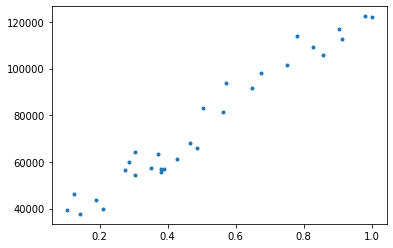

In [3]:
plt.plot(X,Y,'.')

### Regression using Sklearn (Python package)

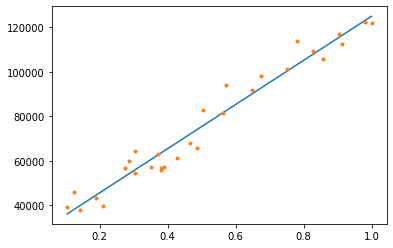

solpe =  99224.60437527833 intercept =  25792.20019866868


In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
res = model.fit(X.reshape((len(X),1)), Y)
predictions = model.predict(X.reshape((len(X),1)))
plt.plot(X, predictions)
plt.plot(X,Y,'.')
plt.show()
print("solpe = ", res.coef_[0],"intercept = ",res.intercept_)

### Regression using a simple Neural Network

In [34]:
from tensorflow.keras import optimizers
# Create the Model once!
model = keras.Sequential()
#The first layer is called an Input layer and has the shape of our input data

#add as much Dense layers as you want 
model.add(Dense(1,input_dim=1,activation='linear'))
model.summary()

opt = optimizers.SGD(lr=0.01)
model.compile(optimizer=opt, 
                  loss='mse')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [48]:
#Callbacks for easier Training
#Train the Model with the training and validation Data
#a=np.array(50000,dtype="float32",ndmin=2)
#b=np.array(20000,dtype="float32",ndmin=1)
#model.set_weights([a,b])

def lr_scheduler(epoch):
    if epoch < 15:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (15 - epoch))

lr_scheduler_cbk = tf.keras.callbacks.LearningRateScheduler(lr_scheduler,verbose=0)

history = model.fit(X, Y, epochs=2000,batch_size=30,verbose=False,callbacks=[lr_scheduler_cbk])
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [49]:
a,b = model.get_weights()
print("slope=",a[0][0],"intercept=",b[0])

slope= 99221.5 intercept= 25793.818


In [50]:
pred = model.predict(X)

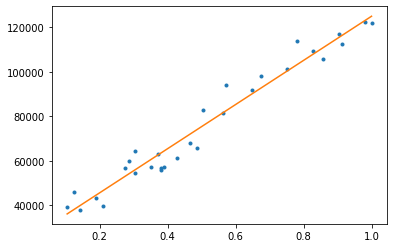

In [51]:
plt.plot(X,Y,'.')
plt.plot(X,pred)

## Try it with the Boston Housing from the Notebook bevor TODO

In [ ]:
# YOUR TURN


## Part 2: Sinuswave Prediction with Feed Forward Neural Networks

Let's start with using a fully-connected neural network to do predict the shape of datapoints, so called regression. The following image highlights the difference between regression and classification (see part 2). Given an observation as input, **regression** outputs a continuous value (e.g., exact temperature) and classificaiton outputs a class/category that the observation belongs to.

<img src="https://i.stack.imgur.com/u3TNL.png" alt="classification_regression" width="400"/>

Now, we load the dataset. Loading the dataset returns six NumPy arrays:

* The `train points X` and `train points Y` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *validation set*, the `validation X`, and `validation Y` arrays.
* As we created the points based on a ground truth sinusoid, we also get two arrays `ground truth X` and `ground truth y`

#### refer to other notebook, maybe they want to create their own dataset

In [6]:
# Example sinusoid dataset
def createDataset_Sinusoid(xmin=-10., xmax=10, noise_std=.2):
    num_data = 1000
    # Create the noise training data
    X_train = np.atleast_2d(np.linspace(xmin, xmax, num_data, dtype=np.float32)).T
    y_train = np.sin(X_train) + np.atleast_2d(np.random.normal(0, noise_std, size=num_data).astype(np.float32)).T

    # Create the ground truth
    X_gt = X_train
    y_gt = np.sin(X_gt)

    # Create the validation data
    X_val = np.atleast_2d(np.linspace(xmin-2, xmax+2, num_data, dtype=np.float32)).T
    y_val = np.sin(X_val) + np.atleast_2d(np.random.normal(0, noise_std, size=num_data).astype(np.float32)).T
    return [X_gt, y_gt,X_train, y_train, X_val, y_val]

X_gt,y_gt,X_train,y_train,X_val,y_val = createDataset_Sinusoid()

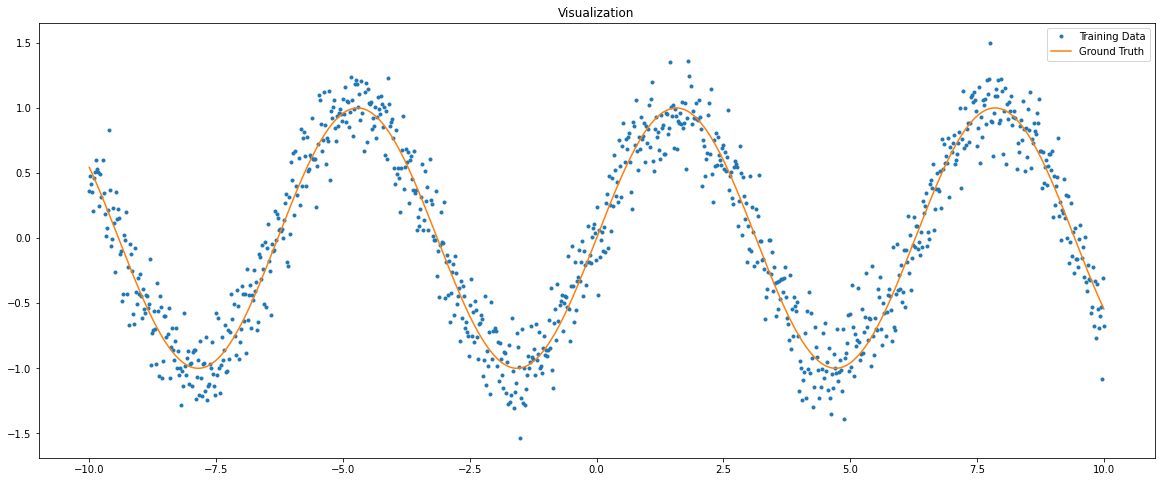

In [7]:
#Visualize the Data
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
ax.set_title('Visualization')
ax.plot(X_train,y_train,'.',label='Training Data')
ax.plot(X_gt,y_gt,label="Ground Truth")
ax.legend()

### Build the model

Building the neural network requires configuring the layers of the model, then compiling the model. First we stack a few layers together using `keras.Sequential`. The number of Layers is very dependend on the tasks you want to perform.

#### The Number of Hidden Layers

| Num Hidden Layers       | Result        |  
| ----------------------- |:------------- | 
| None               | Only capable of representing linear separable functions or decisions.      |
| 1          | Can approximate any function that contains a continuous mapping from one finite space to another.      |
| 2          | Can represent an arbitrary decision boundary to arbitrary accuracy <br> with rational activation functions and can approximate any smooth mapping to any accuracy.     |
| >2          | Additional layers can learn complex representations (sort of automatic feature engineering) for layer layers.      |

#### The Number of Neurons in the Hidden Layers

There are many rule-of-thumb methods for determining an acceptable number of neurons to use in the hidden layers, such as the following:

* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.
These three rules provide a starting point for you to consider the number of neurons. There is also some research about this topic: https://www.hindawi.com/journals/mpe/2013/425740/


Next we configure the loss function, optimizer, and metrics to monitor. These are added during the model's compile step:

* *Loss function* - measures how accurate the model is during training, we want to minimize this with the optimizer.
* *Optimizer* - how the model is updated based on the data it sees and its loss function.
* *Metrics* - used to monitor the training and testing steps.

Let's build a network with multiple hidden layer of * insert number of neurons here* neurons, and use mean squared error (MSE) as the loss function (most common one for regression problems):

For creating a Fully Connected Neural Network we will use so called Dense Layers. One Dense Layers represents a number of neurons that are 'fully connected' with those in the Layer bevor it. In Python adding Dense Layers to the Network will look like this:

```python
# Create the Model once!
model = keras.Sequential()
#The first layer is called an Input layer and has the shape of our input data
model.add(Input(shape=(X_train.shape[1]), name='input'))
#add as much Dense layers as you want 
model.add(Dense(256, activation='relu',name='Hidden_Layer_1'))
```

The last layer of the Network should also be a dense layer and the number of neurons depends on the task you want to do. In this example we want to predict y coordinates based on x coordinates, so the output should only have 1 neuron.

In [8]:
def build_model():
# Create the Model once!
    model = keras.Sequential()
    #The first layer is called an Input layer and has the shape of our input data
    model.add(Input(shape=(X_train.shape[1]), name='input'))
    #add as much Dense layers as you want 
    model.add(Dense(256, activation='relu',name='Hidden_Layer_1'))

    model.add(Dense(256,activation='relu'))

    model.add(Dense(128,activation='relu'))
    # Output Layer with 1 Neuron as Output
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam', 
                  loss='mse')
    return model

<details>
<summary><b>Click here for one possible solution</b></summary>
    
```python
# Create the Model once!
model = keras.Sequential()
#The first layer is called an Input layer and has the shape of our input data
model.add(Input(shape=(X_train.shape[1]), name='input'))
#add as much Dense layers as you want 
model.add(Dense(256, activation='relu',name='Hidden_Layer_1'))
    
model.add(Dense(256,activation='relu'))

model.add(Dense(128,activation='relu'))
# Output Layer with 1 Neuron as Output
model.add(Dense(y_train.shape[1]))

```
</details>


### Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the `train_features` and `train_labels` arrays.
2. The model learns to associate features and labels.
3. We ask the model to make predictions about a test set—in this example, the `test_features` array. We verify that the predictions match the labels from the `test_labels` array. 

To start training,  call the `model.fit` method—the model is "fit" to the training data:

In [9]:
# Build the model and show the layers
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_1 (Dense)       (None, 256)               512       
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 99,329
Trainable params: 99,329
Non-trainable params: 0
_________________________________________________________________


## Training and logging the network

There are a few very importent metrics we need to look at while training the Network. As described in the earlier notebooks, the loss is very important. So while training we want to display it so that we can make sure our network learns something and isnt doing bad stuff. 

This is done by the model.fit function. Here we specify the train and the validation data and while training we get a nice output that shows us all the important values like validation loss and the training loss. 

On the Other hand we want to look at this data after we trained the model. We can use the output of the model.fit function after training to view the raw data ourself or we use so called tensorboard. For using that we need to specify a log file and location and use the tensorboard as callback for the model.fit function.

In [10]:
#Callbacks for easier Training
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# We can specify multiple callbacks for one training
# early stopping helps us stopping the training early if the loss isnt decresing anymore
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
# tensorboard lets us view at the training data afterwards! 
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

#Train the Model with the training and validation Data
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val,y_val),
                    callbacks=[early_stop,tensorboard_callback])


# Manual plotting the training data after the training is done via the history dataframe
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


Epoch 1/100
 1/32 [..............................] - ETA: 0s - loss: 0.7624WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
32/32 [==============================] - 0s 7ms/step - loss: 0.5340 - val_loss: 0.5585
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.5027 - val_loss: 0.6130
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.4863 - val_loss: 0.6454
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.4722 - val_loss: 0.5894
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4111 - val_loss: 0.5755
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3669 - val_loss: 0.4725
Epoch 7/100
32/32 [==============================] - 0s 3ms/step 

In [11]:
%tensorboard --logdir logs --port 6006 --bind_all

Now, let's plot the loss function measure on the training and validation sets. The validation set is used to prevent overfitting ([learn more about it here](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)). However, because our network is small, the training convergence without noticeably overfitting the data as the plot shows.

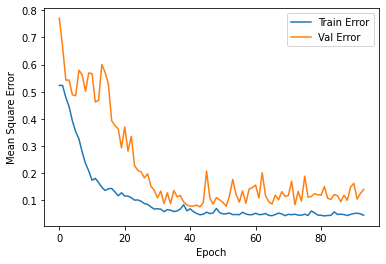

In [17]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.plot(hist['epoch'], hist['loss'], label='Train Error')
plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
plt.legend()

We trained the model to predict the Y Value based on the X Value. Now we can test it by predicting with some test data

In [18]:
y_pred = model.predict(X_val)

Next, compare how the model performs on the test dataset:

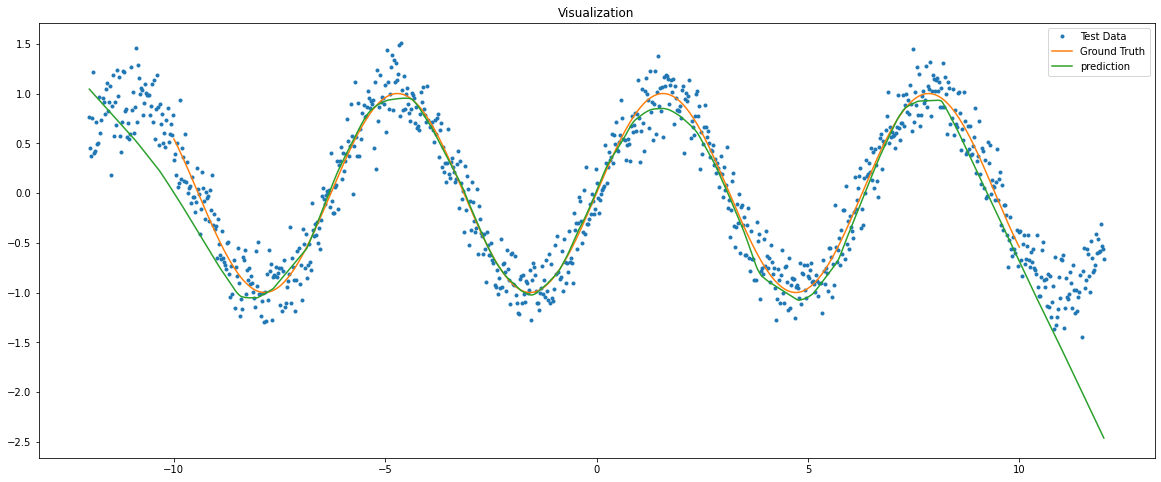

In [19]:
#Visualize the Data
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
ax.set_title('Visualization')

# First we plot the Data we predicted on
ax.plot(X_val,y_val,'.',label='Test Data')
# The Ground Truth
ax.plot(X_gt,y_gt,label="Ground Truth")
# We predicted the y Value based on the X_val value
ax.plot(X_val,y_pred,label="prediction")
ax.legend()

### Improve the model
Now you have some time to improve the prediction. If you have any question just ask.
<details>
  <summary> Click here for some tips to improve the model:</summary>

  1. Try adding more Dense Layers

  2. Maybe Dropout makes your predictions more robust ;)

  3. Increase Training Time

  4. Change the optimizer (SGD,ADAM,ADAMAX)
</details>
